# Evaluate model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Setup

### Import packages

In [2]:
from fastai.vision import *

import IPython.display as ipd
from tqdm import tqdm_notebook

### Instantiate ImageDataBunch

In [3]:
pat = r'/(\w+)_\d+.jpg'

In [4]:
from pathlib import Path
import numpy as np

path_img = "../mfc_dataset_3666"
fnames = list(Path(path_img).rglob('*.jpg')) + list(Path(path_img).rglob('*.jpeg')) + list(Path(path_img).rglob('*.png'))
np.random.seed(42)
np.random.shuffle(fnames)
fnames[:5]


[PosixPath('../mfc_dataset_3666/Male_28963565.jpg'),
 PosixPath('../mfc_dataset_3666/Female_25257868.jpg'),
 PosixPath('../mfc_dataset_3666/Male_33367437.jpg'),
 PosixPath('../mfc_dataset_3666/Female_25260435.jpg'),
 PosixPath('../mfc_dataset_3666/Male_32079978.jpg')]

['Female', 'Male']


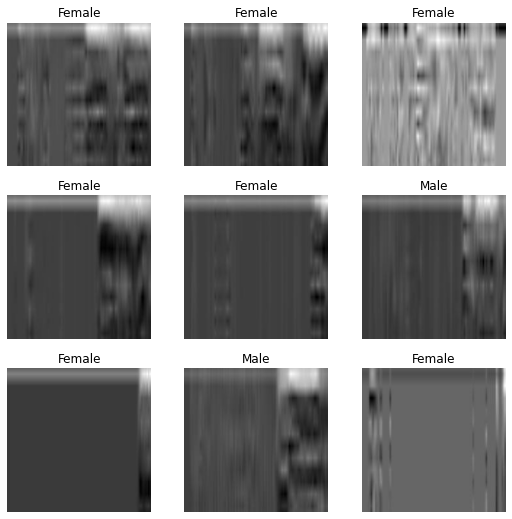

In [5]:
from fastai.vision.all import *
# Use DataBlock and DataLoaders instead of ImageDataBunch
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=RegexLabeller(pat)
)

dls = dblock.dataloaders(path_img, bs=64)
# Show batch and classes
dls.show_batch()
print(dls.vocab)
# You can use dls to train your model with cnn_learner, lr_find, fit_one_cycle, etc.


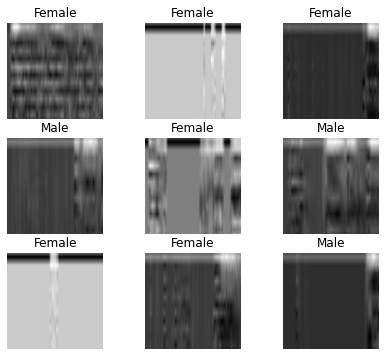

In [6]:
dls.show_batch(nrows=3, ncols=3, figsize=(7,6))


## Analyze mistakes

In [20]:
# learn = cnn_learner(dls, models.resnet34, metrics=error_rate)
# learn.model = load_learner(path_img).model
# # ClassificationInterpretation.from_learner requires the learn to has validation data.
# # However, load_learner(path_img) does not have validation data.
# # Therefore, I had to use the workaround above.

learn = cnn_learner(dls, models.resnet34, metrics=error_rate)

# Provide the correct file path to the exported learner file
learner_path = "model_3666_step2.pkl"

# Load the learner model from the exported file
learn.model = load_learner(learner_path).model


In [21]:
interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)  # Assuming validation data is at index 1



In [22]:
losses, idxs = interp.top_losses()  # only uses data from the validation set

<div style="text-align: justify">
The outliers displayed as MFCs and the Grad-CAM heatmaps are not intuitive because we humans can't read off sounds from MFCs:
</div>

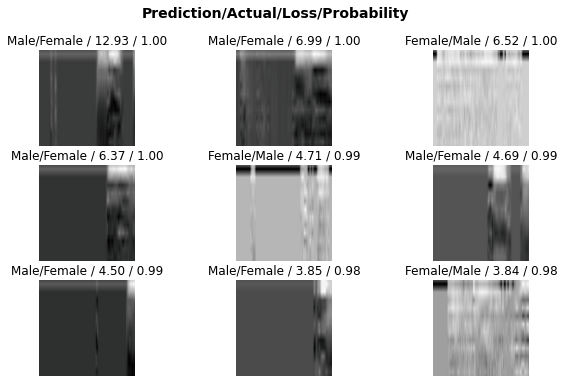

In [23]:
interp.plot_top_losses(9, figsize=(10, 6))

Instead, let's try hearing the top losses.

In [38]:
def load_json(json_fpath):
    with open(json_fpath, 'r') as json_f:
        return json.load(json_f)

In [39]:
try:
    male_idxs_to_wav_fpaths = load_json('../maps/male_idxs_to_wav_fpaths_3666.json')
    female_idxs_to_wav_fpaths = load_json('../maps/female_idxs_to_wav_fpaths_3666.json')
except FileNotFoundError as e:
    print(f"File not found: {e.filename}")
except Exception as e:
    print(f"An error occurred: {e}")


File not found: ../maps/male_idxs_to_wav_fpaths_3666.json


In [37]:
# # reference: https://forums.fast.ai/t/how-to-get-data-val-ds-fnames-in-fastai-v1-0/37231
# for mfc_path in dls.valid_ds.x.items[idxs][:5]:
#     mfc_path = str(mfc_path)
#     print(mfc_path, end='|')
#     wav_fpath = female_idxs_to_wav_fpaths[mfc_path] if 'female' in mfc_path else male_idxs_to_wav_fpaths[mfc_path]
#     print(wav_fpath)
#     ipd.display(ipd.Audio(wav_fpath))


for idx in idxs[:5]:
    item = dls.valid_ds.items[idx]
    print(item, end='|')
    
    # Extracting audio file path based on your data structure
    wav_fpath = (
        female_idxs_to_wav_fpaths[str(item)] 
        if 'female' in str(item) 
        else male_idxs_to_wav_fpaths[str(item)]
    )
    
    print(wav_fpath)
    ipd.display(ipd.Audio(wav_fpath))


../mfc_dataset_3666/Female_25247544.jpg|

NameError: name 'female_idxs_to_wav_fpaths' is not defined

### Confusion matrix

The confusion matrix and the F1 score are commonly used to evaluate classifiers:

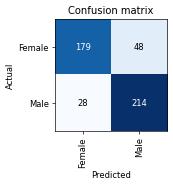

In [32]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

### F1 score

Since this is a binary classification task, we can think of "female" as "true" and "male as "false".

In [33]:
cmat = interp.confusion_matrix()
precision = cmat[0][0] / (cmat[0][0] + cmat[1][0])  # true positives / (true positives + false positives = positive predictions) 
recall = cmat[0][0] / (cmat[0][0] + cmat[0][1])  # true positives / (true positives + false negatives = positive ground truths)
f1_score = 2 / (1 / precision + 1 / recall)

result

In [34]:
f1_score

0.8248847926267281

In [35]:
recall

0.788546255506608

In [36]:
precision

0.8647342995169082